# Task1
## High Level State Representation
- Data is generated by an "expert" player.
- $timeout -sHUP 30m python ./lunar_lander_data_gen.py
    - generates data for 10 minutes
    - saves high level state representation as state_vectors_*.csv
    - saves image files in ./frames/2018-*/frame_2018_*.jpeg
- Train and evaluate a number of supervised machine learning models to predict actions of an "expert" player based off image data.


- Model saved as:
    - ml_states_player.pkl

    Process: CRISP-DM
        Iterating over this workflow
        Assessing data, modeling, evaluating, re-developing
        e.g. Strong accuracies, but poor flight from imbalanced dataset

          -> undersampling

        e.g. Initial learning curves implied immature models

          -> generate more data.



## Imports

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict, \
                                    GridSearchCV,    train_test_split, \
                                    learning_curve,  StratifiedKFold

from sklearn import metrics
        
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

from imblearn.under_sampling import RandomUnderSampler

from my_lib import topn, plot_learning_curve



### View Project Folder

In [2]:
ls

dqn_LunarLander-v2_weights.h5f     __pycache__/
frames/                            README.txt
images_player.mod                  recording/
lunar_lander_data_gen.py*          rl/
lunar_lander_dl_player.py*         state_vectors_2018-04-21-20-41-25.csv
lunar_lander_ml_images_player.py*  Task1.ipynb
lunar_lander_ml_states_player.py*  Task2.ipynb
ml_states_player.pkl               Task3.ipynb
my_lib.py                          Task3.py*
player.mod


### Plug In Data

In [3]:

#Other User
#data_file = "state_vectors_*.csv"

#Andy
data_file = "state_vectors_2018-04-21-20-41-25.csv"

#Conor
#data_file = "../state_vectors_2018-04-20-15-12-38.csv"


### Experiment Parameters

In [4]:
#Sample for faster processing
sample_frac = 0.10

#Stratify to preserve label weightings
grid_search_cv_folds = StratifiedKFold(5, shuffle=True)
cv_experiment_folds = StratifiedKFold(10, shuffle=True)
learning_curve_folds = StratifiedKFold(5, shuffle=True)

### Prepare Dataset
- Undersampled to balance classes.
    - Stabalizer engines are important but infrequent actions.
    - Undersampling helps with model recall/sensitivity.
    - It will be more inclined to use the stablisers appropriately.
- Sampling Dataset to improve processing time.
    - Tune with medium amount of data for find generalizable parameters
  
#### Actions:
        - 0 = no action, 
        - 1=left, 
        - 2=up, 
        - 3=right

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38484 entries, 0 to 73
Data columns (total 8 columns):
pos_x                      38484 non-null float64
pos_y                      38484 non-null float64
vel_x                      38484 non-null float64
vel_y                      38484 non-null float64
ship_lander_angle          38484 non-null float64
ship_lander_angular_vel    38484 non-null float64
leg_1_ground_contact       38484 non-null float64
leg_2_ground_contact       38484 non-null float64
dtypes: float64(8)
memory usage: 3.9 MB


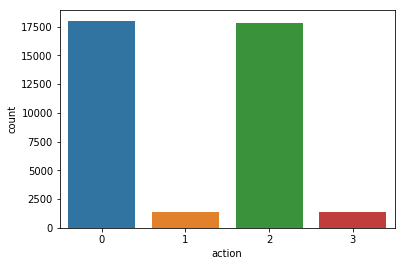

In [5]:
# load dataset for data file
df = pd.read_csv(data_file, header=0, index_col='step')

# split data into X,y (descriptive features, target feature)
X,y = df[[col for col in list(df) if col!='action']], df['action']

#view class label chart
sns.countplot(y)

#show dataframe infromation
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5388 entries, 0 to 5387
Data columns (total 8 columns):
0    5388 non-null float64
1    5388 non-null float64
2    5388 non-null float64
3    5388 non-null float64
4    5388 non-null float64
5    5388 non-null float64
6    5388 non-null float64
7    5388 non-null float64
dtypes: float64(8)
memory usage: 336.8 KB


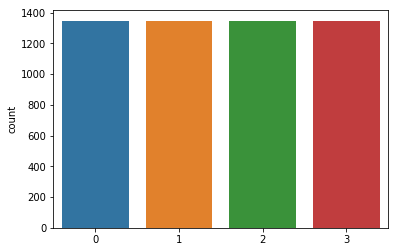

In [6]:
# Apply the random under-sampling
# DataSet is Approx 7 times smaller
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, idx_resample = rus.fit_sample(X,y)
sns.countplot(y_rus)
pd.DataFrame(X_rus).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4310 entries, 0 to 4309
Data columns (total 8 columns):
0    4310 non-null float64
1    4310 non-null float64
2    4310 non-null float64
3    4310 non-null float64
4    4310 non-null float64
5    4310 non-null float64
6    4310 non-null float64
7    4310 non-null float64
dtypes: float64(8)
memory usage: 269.5 KB


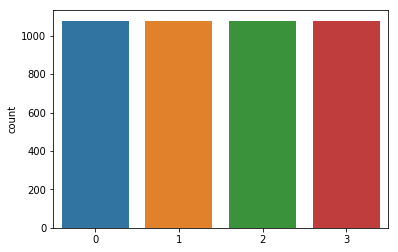

In [7]:
#Take stratified sample for experimenting
n_samples=int(len(y_rus)*sample_frac)
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, 
                                                    train_size=0.80, test_size=20, 
                                                    stratify=y_rus, shuffle=True)
sns.countplot(y_train)
pd.DataFrame(X_train).info()


### Algorithms and Search Space
- RandomForest
    - Forest of Decision Trees each with only subset of features
    - Members tend to be "weaker" but quite diverse.
    - Ensembles non-linear, volatile classifiers
    - Flexible learner for most problems.
    - Relativly quick to train, predict and is compact in memory for most scales of data.
    - Gives good baseline for most problems
    

- Bagging Classifier
    - Forest of Decision Trees each with entire feature set available
    - Members tend to be stronger, but less diverse.
    - Similar benefits to random forest.
    

- MLP
    - Highly non-linear
    - Particularly goog at extracting non linear relationships.
    - Generally long train times.
    - Good baseline for Nueral Nets
    


In [8]:
# list of chosen classifiers.
clfs = [RandomForestClassifier, MLPClassifier, BaggingClassifier]

# dictionary for grid search parameters
param_grids= {
    'RandomForestClassifier': {
        'criterion' : ['gini', 'entropy'],
        'n_estimators' : [10,15,20],
        'max_features' : [None, 5, 8]
    },
    'MLPClassifier': {
        'activation' : ['relu',],
        'hidden_layer_sizes' : [(8,8), (16,16), (128,), (256,)],
        'solver' : ['adam'],
        'learning_rate' : ['adaptive', 'constant'],
        'early_stopping' : [True]
    },
    'BaggingClassifier' : {
        'n_estimators' : [5,10,15,20],
        'max_samples' : [0.5,0.75,1],
        'max_features' : [0.5,0.75,1]
    }
}

### Execute Search

In [9]:
%%time
#store the best params and scores for each classifier
stored_grid_searches={}

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    current_GS = GridSearchCV(clf(), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=0, 
                              return_train_score=True).fit(X_train, y_train)
    
    # store grid search object for each classifier
    stored_grid_searches[clf_name]=current_GS

CPU times: user 1min 25s, sys: 504 ms, total: 1min 25s
Wall time: 1min 14s


### Inspect Search Results

- GridSearch results are double checked
- Models are considered on train/prediction times and accuracy.
- In each case, the best params were judged to be those identified by the grid search.

In [10]:
#store selcted params for each classifier
selected_params={}
    

In [11]:
#print top3 results
RF_GS = stored_grid_searches['RandomForestClassifier']
topn(RF_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,1.070,0.005,0.777,0.998,entropy,None,20,"{'max_features': None, 'n_estimators': 20, 'cr...",1,0.772,...,0.783,0.999,0.770,0.997,0.778,0.996,0.013,0.0,0.005,0.001
8,0.377,0.006,0.776,0.997,gini,8,20,"{'max_features': 8, 'n_estimators': 20, 'crite...",2,0.782,...,0.780,0.997,0.760,0.996,0.779,0.998,0.013,0.0,0.008,0.001
17,1.062,0.005,0.776,0.998,entropy,8,20,"{'max_features': 8, 'n_estimators': 20, 'crite...",3,0.770,...,0.784,0.997,0.766,0.998,0.777,0.998,0.014,0.0,0.007,0.000


In [12]:
print("best params:", RF_GS.best_params_)
print("best score:", RF_GS.best_score_)

#store best random forest
selected_params['RandomForestClassifier'] = RF_GS.best_params_

best params: {'max_features': None, 'n_estimators': 20, 'criterion': 'entropy'}
best score: 0.777030162413


In [13]:
#print top3 results
MLP_GS = stored_grid_searches['MLPClassifier']
topn(MLP_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_early_stopping,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.236,0.002,0.671,0.668,relu,True,"(128,)",constant,adam,"{'solver': 'adam', 'learning_rate': 'constant'...",...,0.653,0.637,0.621,0.640,0.727,0.721,0.162,0.0,0.040,0.040
7,0.315,0.003,0.670,0.677,relu,True,"(256,)",constant,adam,"{'solver': 'adam', 'learning_rate': 'constant'...",...,0.628,0.611,0.623,0.643,0.695,0.700,0.158,0.0,0.036,0.043
6,0.326,0.003,0.666,0.673,relu,True,"(256,)",adaptive,adam,"{'solver': 'adam', 'learning_rate': 'adaptive'...",...,0.628,0.627,0.681,0.712,0.722,0.723,0.165,0.0,0.041,0.048


In [14]:
print("best params:", MLP_GS.best_params_)
print("best score:",  MLP_GS.best_score_)

selected_params['MLPClassifier'] = MLP_GS.best_params_

best params: {'solver': 'adam', 'learning_rate': 'constant', 'early_stopping': True, 'hidden_layer_sizes': (128,), 'activation': 'relu'}
best score: 0.671229698376


In [15]:
#print top3 results
BAG_GS = stored_grid_searches['BaggingClassifier']
topn(BAG_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_max_samples,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.249,0.005,0.750,0.989,0.75,0.75,20,"{'max_features': 0.75, 'n_estimators': 20, 'ma...",1,0.764,...,0.731,0.991,0.760,0.989,0.727,0.986,0.009,0.0,0.018,0.002
15,0.185,0.005,0.750,0.960,0.75,0.5,20,"{'max_features': 0.75, 'n_estimators': 20, 'ma...",2,0.760,...,0.761,0.962,0.742,0.959,0.735,0.954,0.002,0.0,0.010,0.003
14,0.140,0.004,0.747,0.952,0.75,0.5,15,"{'max_features': 0.75, 'n_estimators': 15, 'ma...",3,0.736,...,0.741,0.950,0.749,0.950,0.766,0.954,0.004,0.0,0.011,0.003


In [16]:
print("best params:", BAG_GS.best_params_)
print("best score:", BAG_GS.best_score_)

selected_params['BaggingClassifier'] = BAG_GS.best_params_

best params: {'max_features': 0.75, 'n_estimators': 20, 'max_samples': 0.75}
best score: 0.750348027842


### 10xCV Experiment : Train Set

In [17]:
# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(clf(**params), 
                                                  X_train, y_train,
                                                  cv=cv_experiment_folds)) 

# print the avg CVx10 score.
pd.DataFrame(cv_scores, [0]).round(3)

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.761,0.701,0.777


### Learning Curves : Train Set

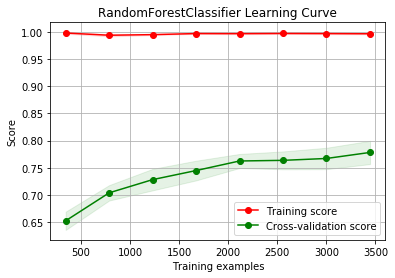

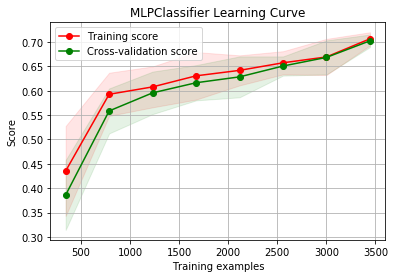

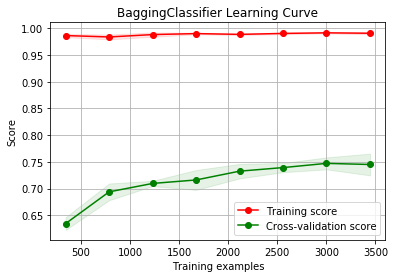

In [18]:
# Print learning curves for each model
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    plot_learning_curve(clf(**params), 
                        clf_name+' Learning Curve', 
                        X_train, y_train, 
                    cv=learning_curve_folds)


### Holdout Experiment

In [19]:
#Evaluate with Test dataset
holdout_scores ={}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    model = clf(**params)
    
    #fit model and make predictions
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #store holdout scores
    holdout_scores[clf_name] = metrics.accuracy_score(y_test, pred)
    
    # Print performance overview
    print(clf_name)
    print('Report:\n',metrics.classification_report(y_test, pred))
    print("Confusion Matrix\n", metrics.confusion_matrix(y_test, pred))

    #Accuracy
    print('Accuracy:',metrics.accuracy_score(y_test, pred))
    print('='*100)

    
    
pd.DataFrame(holdout_scores, [0]).round(3)

RandomForestClassifier
Report:
              precision    recall  f1-score   support

          0       0.67      0.80      0.73         5
          1       0.83      1.00      0.91         5
          2       0.67      0.40      0.50         5
          3       1.00      1.00      1.00         5

avg / total       0.79      0.80      0.78        20

Confusion Matrix
 [[4 0 1 0]
 [0 5 0 0]
 [2 1 2 0]
 [0 0 0 5]]
Accuracy: 0.8
MLPClassifier
Report:
              precision    recall  f1-score   support

          0       0.75      0.60      0.67         5
          1       0.71      1.00      0.83         5
          2       0.50      0.40      0.44         5
          3       0.60      0.60      0.60         5

avg / total       0.64      0.65      0.64        20

Confusion Matrix
 [[3 1 1 0]
 [0 5 0 0]
 [0 1 2 2]
 [1 0 1 3]]
Accuracy: 0.65
BaggingClassifier
Report:
              precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1   

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.7,0.65,0.8


### Select Best Learner

In [21]:
#Pick best model
selected_model = MLPClassifier
model_name = str(selected_model).split(".")[-1][:-2]
params = selected_params[model_name]
model = selected_model(**params)

#train model
model.fit(X_rus, y_rus)

#verify its functioning correctly
model.predict(X_test)

#save model
filename = 'ml_states_player.pkl'
joblib.dump(model, filename)

#load model
model = joblib.load(filename)

#Verify its still working
model.predict(X_test)

#summary
model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(128,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)